# Energieverbruik en -productie van Nederland

Energie is duur. Dat weet iedereen. Tijdens dit project gaan "de Potter Robin" & "Verhaegen Stijn" een analyse doen over het energieverbruik en de productie ervan in Nederland.

## Onderzoeksvragen
- Hoeveel energieverbruik en -productie is er in Nederland voor de afgelopen jaren?
- Is er een verband tussen het verbruik van elektriciteit en gas?
- Is er een bepaalde trend die zich voortdoet ?

## Inhoud

1. Energieverbruik
2. Elektriciteitsproductie

## 1. Energieverbruik

### 1.1 Voorbereiding

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.rdd import RDD
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql.functions import *
import glob
import os

In [2]:
spark = SparkSession.builder.appName("EnergyConsumption").getOrCreate()
sc = spark.sparkContext

21/12/15 16:55:19 WARN Utils: Your hostname, Stijns-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.120 instead (on interface en0)
21/12/15 16:55:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/15 16:55:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Path naar de data

In [3]:
path_gas = r"./data/Gas/"
path_electricity = r"./data/Electricity/"

Het schema dat we zullen gebruiken voor het dataframe van gas en elektriciteit. 

In [4]:
schema = StructType([
    StructField('net_manager', StringType(), True),
    StructField('purchase_area', StringType(), True),
    StructField('street', StringType(), True),
    StructField('zipcode_from', StringType(), True),
    StructField('zipcode_to', StringType(), True),
    StructField('city', StringType(), True),
    StructField('num_connections', DoubleType(), True),
    StructField('delivery_perc', DoubleType(), True),
    StructField('perc_of_active_connections', DoubleType(), True),
    StructField('type_conn_perc', DoubleType(), True),
    StructField('type_of_connection', StringType(), True),
    StructField('annual_consume', DoubleType(), True),
    StructField('year', IntegerType(), True),
    StructField('file_name', StringType(), True)
  ])

Hier declareren we de make_df functie die de raw data zal omzetten naar een DataFrame. We verwijderen ook een aantal files omdat de data van '*coteq_gas*' hetzelfde is van 2013 - 2018. Ook hebben wij '*rendo_gas_2019*' verwijderd aangezien die null values bevat.

In [5]:
def make_df(path):
    rdd_full = sc.emptyRDD()
    df_full = spark.createDataFrame(rdd_full,schema)
    for filename in os.listdir(path):
        if(filename == "rendo_gas_2019.csv" or 
           filename == "coteq_gas_2014.csv" or 
           filename == "coteq_gas_2015.csv" or 
           filename == "coteq_gas_2016.csv" or 
           filename == "coteq_gas_2017.csv" or 
           filename == "coteq_gas_2018.csv"):
#            filename == "endurisgas_01012015.csv"
            print("removed " + filename)
        else:
            # Read file and assign data
            year = filename[-8:]
            year = year[0:4]
            data = spark.read.option("header","true").option("inferSchema", "true").csv(path + filename, sep=",")
            listColumns = data.columns
            if 'ï»¿NETBEHEERDER' in listColumns:
                data = data.withColumnRenamed("ï»¿NETBEHEERDER","net_manager")
            data = data.select(data.net_manager, data.purchase_area, data.street, data.zipcode_from,
                               data.zipcode_to,
                               data.city,
                               data.num_connections,
                               data.delivery_perc,
                               data.perc_of_active_connections,
                               data.type_conn_perc,
                               data.type_of_connection,
                               data.annual_consume)
            data = data.withColumn('year', lit(int(year)))
            data = data.withColumn('file_name', lit(filename))
            df_full = df_full.union(data)
    return df_full

We gebruiken de functie make_df(path) die we juist gedefinieerd hebben om al de gasdata in te lezen. 

In [6]:
df_gas = make_df(path_gas)


removed coteq_gas_2018.csv
removed rendo_gas_2019.csv
removed coteq_gas_2015.csv
removed coteq_gas_2014.csv
removed coteq_gas_2016.csv
removed coteq_gas_2017.csv


In [7]:
df_gas.show(vertical=True)

-RECORD 0------------------------------------------
 net_manager                | 8717127750009        
 purchase_area              | GAS Gastransport ... 
 street                     | Poststraat           
 zipcode_from               | 4301AA               
 zipcode_to                 | 4301AA               
 city                       | ZIERIKZEE            
 num_connections            | 14.0                 
 delivery_perc              | 100.0                
 perc_of_active_connections | 100.0                
 type_conn_perc             | 50,00                
 type_of_connection         | G4                   
 annual_consume             | 3736.0               
 year                       | 2015                 
 file_name                  | endurisgas_010120... 
-RECORD 1------------------------------------------
 net_manager                | 8717127750009        
 purchase_area              | GAS Gastransport ... 
 street                     | Poststraat           
 zipcode_fro

In [8]:
df_gas.count()

3665480

In [9]:
df_gas.printSchema()

root
 |-- net_manager: string (nullable = true)
 |-- purchase_area: string (nullable = true)
 |-- street: string (nullable = true)
 |-- zipcode_from: string (nullable = true)
 |-- zipcode_to: string (nullable = true)
 |-- city: string (nullable = true)
 |-- num_connections: double (nullable = true)
 |-- delivery_perc: double (nullable = true)
 |-- perc_of_active_connections: double (nullable = true)
 |-- type_conn_perc: string (nullable = true)
 |-- type_of_connection: string (nullable = true)
 |-- annual_consume: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- file_name: string (nullable = true)



Hoewel we in het schema meegeven dat de kolom 'type_conn_perc' het datatype Double heeft, is dit nog niet het geval. Het datatype is String. We denken dat dit komt omdat de values komma's bevatten. Bv: 50,0 ipv 50.0. We veranderen dus alle komma's met punten voor deze kolom. Als we dit niet doen en we casten deze kolom meteen naar een double, dan worden de waardes die een komma bevatten omgezet naar null. 

In [10]:
df_gas = df_gas.withColumn('type_conn_perc', regexp_replace('type_conn_perc', '[,]', '.'))

In [11]:
df_gas.show(vertical=True)

-RECORD 0------------------------------------------
 net_manager                | 8717127750009        
 purchase_area              | GAS Gastransport ... 
 street                     | Poststraat           
 zipcode_from               | 4301AA               
 zipcode_to                 | 4301AA               
 city                       | ZIERIKZEE            
 num_connections            | 14.0                 
 delivery_perc              | 100.0                
 perc_of_active_connections | 100.0                
 type_conn_perc             | 50.00                
 type_of_connection         | G4                   
 annual_consume             | 3736.0               
 year                       | 2015                 
 file_name                  | endurisgas_010120... 
-RECORD 1------------------------------------------
 net_manager                | 8717127750009        
 purchase_area              | GAS Gastransport ... 
 street                     | Poststraat           
 zipcode_fro

Nu we dit gedaan hebben moeten we deze kolom nog casten naar het datatype Double. 

In [12]:
df_gas = df_gas.withColumn('type_conn_perc', df_gas['type_conn_perc'].cast(DoubleType()))

In [13]:
df_gas.printSchema()

root
 |-- net_manager: string (nullable = true)
 |-- purchase_area: string (nullable = true)
 |-- street: string (nullable = true)
 |-- zipcode_from: string (nullable = true)
 |-- zipcode_to: string (nullable = true)
 |-- city: string (nullable = true)
 |-- num_connections: double (nullable = true)
 |-- delivery_perc: double (nullable = true)
 |-- perc_of_active_connections: double (nullable = true)
 |-- type_conn_perc: double (nullable = true)
 |-- type_of_connection: string (nullable = true)
 |-- annual_consume: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- file_name: string (nullable = true)



Het schema van het dataframe df_gas is nu in orde. Elke kolom heeft het juiste datatype. 

We doorlopen nu hetzelfde proces voor de elektriciteitsdata. We gebruiken de functie make_df(path) om al de elektriciteitsdata in te lezen.

In [14]:
df_electricity = make_df(path_electricity)

In [15]:
df_electricity.show(vertical=True)

-RECORD 0------------------------------------------
 net_manager                | 8716874000009        
 purchase_area              | Stedin Utrecht       
 street                     | Egelshoek            
 zipcode_from               | 1213RC               
 zipcode_to                 | 1231AB               
 city                       | HILVERSUM            
 num_connections            | 30.0                 
 delivery_perc              | 90.0                 
 perc_of_active_connections | 100.0                
 type_conn_perc             | 80.0                 
 type_of_connection         | 3x25                 
 annual_consume             | 5909.0               
 year                       | 2019                 
 file_name                  | stedin_electricit... 
-RECORD 1------------------------------------------
 net_manager                | 8716874000009        
 purchase_area              | Stedin Utrecht       
 street                     | Rembrandtlaan        
 zipcode_fro

In [16]:
df_electricity.count()

4077352

In [17]:
df_electricity.printSchema()

root
 |-- net_manager: string (nullable = true)
 |-- purchase_area: string (nullable = true)
 |-- street: string (nullable = true)
 |-- zipcode_from: string (nullable = true)
 |-- zipcode_to: string (nullable = true)
 |-- city: string (nullable = true)
 |-- num_connections: double (nullable = true)
 |-- delivery_perc: string (nullable = true)
 |-- perc_of_active_connections: string (nullable = true)
 |-- type_conn_perc: string (nullable = true)
 |-- type_of_connection: string (nullable = true)
 |-- annual_consume: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- file_name: string (nullable = true)



Ook bij het dataframe df_electricity is het schema nog niet correct toegepast. Niet alle kolommen hebben het juiste datatype. Ook hier casten we de kolommen 'delivery_perc', 'perc_of_active_connections' en 'type_conn_perc' naar het datatype dat we in het schema hebben vastgelegd, namelijk een Double. 

In [18]:
df_electricity = df_electricity.withColumn('delivery_perc', df_electricity['delivery_perc'].cast(DoubleType()))
df_electricity = df_electricity.withColumn('perc_of_active_connections', df_electricity['perc_of_active_connections'].cast(DoubleType()))
df_electricity = df_electricity.withColumn('type_conn_perc', df_electricity['type_conn_perc'].cast(DoubleType()))

In [19]:
df_electricity.printSchema()

root
 |-- net_manager: string (nullable = true)
 |-- purchase_area: string (nullable = true)
 |-- street: string (nullable = true)
 |-- zipcode_from: string (nullable = true)
 |-- zipcode_to: string (nullable = true)
 |-- city: string (nullable = true)
 |-- num_connections: double (nullable = true)
 |-- delivery_perc: double (nullable = true)
 |-- perc_of_active_connections: double (nullable = true)
 |-- type_conn_perc: double (nullable = true)
 |-- type_of_connection: string (nullable = true)
 |-- annual_consume: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- file_name: string (nullable = true)



Het schema van het dataframe df_electricity komt nu overeen met het schema dat we hebben opgesteld. De data van het gas- en elektriciteitsverbruik is nu correct ingeladen. 

### 1.2 Analyse gas- en elektriciteitsverbruik
In dit gedeelte gaan we de dataset analyseren om een antwoord proberen te vinden op onze onderzoeksvragen: 

- Hoeveel energieverbruik en -productie is er in Nederland voor de afgelopen jaren?
- Is er een verband met het verbruik van elektriciteit en gas?
- Is er een bepaalde trend die zich voortdoet ?

### 1.2.1 Gemiddeld jaarlijks verbruik gas
Hier geven we weer wat het jaarlijks verbuik is van gas van 2009 tot en met 2020. Om dit waar te maken moeten wij eerst onze data omzetten naar een key value pair waarin het gemiddelde gebruik per jaar staat genoteerd.

In [20]:
key_value_pair_gas = df_gas.rdd.map(lambda l: (l.year, l.annual_consume)).aggregateByKey((0,0), lambda a,b: (a[0] + b, a[1] + 1),lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg_per_year_gas = key_value_pair_gas.mapValues(lambda v: v[0]/v[1]).collect()
avg_per_year_gas

/opt/homebrew/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/opt/homebrew/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/opt/homebrew/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/opt/homebrew/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/opt/homebrew/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling
/opt/homebrew/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with s

[(2009, 1868.7520436999903),
 (2010, 1950.1928932309215),
 (2011, 1908.7926353233634),
 (2012, 1879.4636796287423),
 (2013, 1832.8278565465635),
 (2014, 1848.9595801313028),
 (2015, 1779.309693393873),
 (2016, 1733.865055569192),
 (2017, 1711.1235301038448),
 (2018, 1731.8559092667442),
 (2019, 1721.6104111111708),
 (2020, 1703.4534020854499)]

Nadat deze stap is gebeurt kunnen we de grafiek genereren.

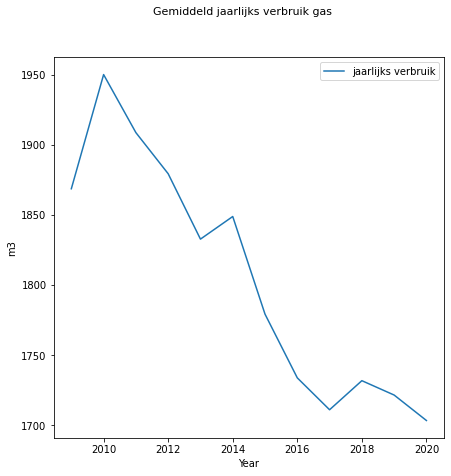

In [21]:
rdd_plot_gas = spark.sparkContext.parallelize(avg_per_year_gas)
df_plot_gas = rdd_plot_gas.toDF()
df_plot_gas = df_plot_gas.sort("_1")
x_axis = df_plot_gas.select("_1").rdd.flatMap(lambda x: x).collect()
y_axis = df_plot_gas.select("_2").rdd.flatMap(lambda x: x).collect()

figure_annual_consume_gas = plt.figure(figsize=(7, 7))
figure_annual_consume_gas.suptitle('Gemiddeld jaarlijks verbruik gas', fontsize=11)
plt_annual_consume_gas = figure_annual_consume_gas.add_subplot(111)
plt_annual_consume_gas.plot(x_axis, y_axis, label = "jaarlijks verbruik")
plt.xlabel("Year")
plt.ylabel("m3")
plt.legend()
plt.show()

We kunnen vaststellen dat het verbuik van gas enorm verminderd is. Heeft dit een corrolatie met het verbuik van elektriciteit? We bekijken het straks door dezelfde analyse te maken voor elektriciteit. Maar we gaan eerst nog het totaal gasverbruik analyseren.

### 1.2.2. Totaal jaarlijks verbruik gas voor Stedin

We gaan nu kijken ofdat we eventueel een verschil zien met het gemiddelde en het totaal verbruik van gas over de jaren heen. Zien we de dalende trend ook terug in het totale gasverbruik of niet ?

We moeten wel onthouden dat er een aantal files weg zijn gehaald namelijk:

coteq_gas_2014.csv
coteq_gas_2015.csv
coteq_gas_2016.csv
coteq_gas_2017.csv
coteq_gas_2018.csv
rendo_gas_2019.csv
Dit kwam omdat de data niet geschikt en/of inconsistent (hetzelfde) was.

Er zijn ook leveranciers die geen data hebben van specifieke jaren. Om een goede vergelijking te kunnen maken zullen we het totaal gasverbruik bekijken voor de leveranciers Stedin en Liander waarvan er wel volledige data beschikbaar is.

Eerst zullen we de data van Stedin bestuderen.

In [22]:
df_plot_gas_stedin = df_gas.filter((df_gas.file_name == "stedin_gas_2009.csv") | \
          (df_gas.file_name == "stedin_gas_2010.csv") | \
          (df_gas.file_name == "stedin_gas_2011.csv") | \
          (df_gas.file_name == "stedin_gas_2012.csv") | \
          (df_gas.file_name == "stedin_gas_2013.csv") | \
          (df_gas.file_name == "stedin_gas_2014.csv") | \
          (df_gas.file_name == "stedin_gas_2015.csv") | \
          (df_gas.file_name == "stedin_gas_2016.csv") | \
          (df_gas.file_name == "stedin_gas_2017.csv") | \
          (df_gas.file_name == "stedin_gas_2018.csv") | \
          (df_gas.file_name == "stedin_gas_2019.csv") | \
          (df_gas.file_name == "stedin_gas_2020.csv")).groupBy('year').sum('annual_consume')
df_plot_gas_stedin.show()

+----+--------------------+
|year| sum(annual_consume)|
+----+--------------------+
|2018|        1.31020748E8|
|2015|        1.36301932E8|
|2013|        1.42071153E8|
|2014|        1.40455646E8|
|2019|        1.27077896E8|
|2020|1.3591490922000086E8|
|2012|        1.43546089E8|
|2009|        1.42069196E8|
|2016|        1.33619789E8|
|2010|        1.42533745E8|
|2011|        1.43005749E8|
|2017|        1.32017049E8|
+----+--------------------+



Nu kunnen we het totaal jaarlijks verbruik van gas van de leverancier Stedin plotten.

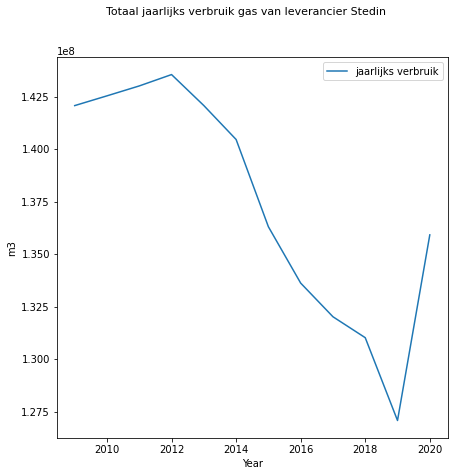

In [23]:
df_plot_gas_stedin = df_plot_gas_stedin.sort("year")
x_axis = df_plot_gas_stedin.select("year").rdd.flatMap(lambda x: x).collect()
y_axis = df_plot_gas_stedin.select("sum(annual_consume)").rdd.flatMap(lambda x: x).collect()

figure_annual_consume_gas_total = plt.figure(figsize=(7, 7))
figure_annual_consume_gas_total.suptitle('Totaal jaarlijks verbruik gas van leverancier Stedin', fontsize=11)
plt_annual_consume_gas_total = figure_annual_consume_gas_total.add_subplot(111)
plt_annual_consume_gas_total.plot(x_axis, y_axis, label = "jaarlijks verbruik")
plt.xlabel("Year")
plt.ylabel("m3")
plt.legend()
plt.show()

Ook hier zien we de neerwaartse trend zoals bij het gemiddelde gasverbruik. Wel is het verbruik in 2020 terug gestegen.

### 1.2.3. Totaal jaarlijks verbruik gas voor Liander

We gaan nu net hetzelfde doen voor de leverancier Liander. Zo kunnen we analyseren of we dezelfde piek krijgen in 2020 voor Liander.

In [24]:
df_plot_gas_liander = df_gas.filter((df_gas.file_name == "liander_gas_01012009.csv") | \
          (df_gas.file_name == "liander_gas_01012010.csv") | \
          (df_gas.file_name == "liander_gas_01012011.csv") | \
          (df_gas.file_name == "liander_gas_01012012.csv") | \
          (df_gas.file_name == "liander_gas_01012013.csv") | \
          (df_gas.file_name == "liander_gas_01012014.csv") | \
          (df_gas.file_name == "liander_gas_01012015.csv") | \
          (df_gas.file_name == "liander_gas_01012016.csv") | \
          (df_gas.file_name == "liander_gas_01012017.csv") | \
          (df_gas.file_name == "liander_gas_01012018.csv") | \
          (df_gas.file_name == "liander_gas_01012019.csv") | \
          (df_gas.file_name == "liander_gas_01012020.csv")).groupBy('year').sum('annual_consume')
df_plot_gas_liander.show()

+----+-------------------+
|year|sum(annual_consume)|
+----+-------------------+
|2018|        2.0243773E8|
|2015|       1.85443332E8|
|2013|       1.95012546E8|
|2014|       1.93033774E8|
|2019|       2.01298517E8|
|2020|       1.99172158E8|
|2012|       2.01351491E8|
|2009|       2.03115469E8|
|2016|       2.02976902E8|
|2010|       2.00868112E8|
|2011|       2.04397515E8|
|2017|       2.01625832E8|
+----+-------------------+



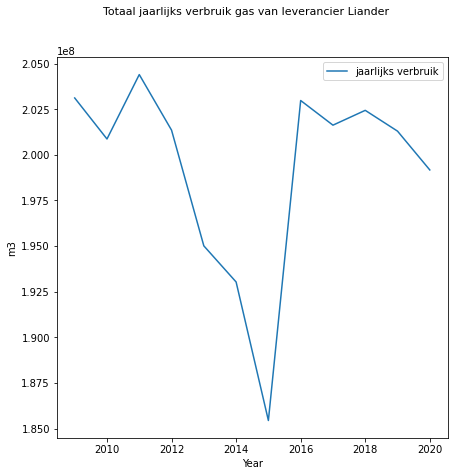

In [25]:
df_plot_gas_liander = df_plot_gas_liander.sort("year")
x_axis = df_plot_gas_liander.select("year").rdd.flatMap(lambda x: x).collect()
y_axis = df_plot_gas_liander.select("sum(annual_consume)").rdd.flatMap(lambda x: x).collect()

figure_annual_consume_gas_total = plt.figure(figsize=(7, 7))
figure_annual_consume_gas_total.suptitle('Totaal jaarlijks verbruik gas van leverancier Liander', fontsize=11)
plt_annual_consume_gas_total = figure_annual_consume_gas_total.add_subplot(111)
plt_annual_consume_gas_total.plot(x_axis, y_axis, label = "jaarlijks verbruik")
plt.xlabel("Year")
plt.ylabel("m3")
plt.legend()
plt.show()

Hier zien we een heel andere trend dan die van het totaal jaarlijks gasverbruik van Stedin en die van het gemiddeld jaarlijks verbruik. Het gasverbruik daalde tot er een stijging was in 2016. Vanaf dan zette de neerwaartse trend zich wel weer voort. 

Een mogelijke verklaring hiervoor is dat Liander in 2016 aan veel meer klanten gas leverde. Maar met zekerheid kunnen we dit niet zeggen. Dit kan wel het onderzoeken waard zijn.

### 1.2.4. Gemiddeld jaarlijks verbruik elektriciteit

Voor het elektriciteitsverbruik zullen we exact dezelfde stappen doorlopen zoals we net gedaan hebben voor gasverbruik.

In [26]:
key_value_pair_elec = df_electricity.rdd.map(lambda l: (l.year, l.annual_consume)).aggregateByKey((0,0), lambda a,b: (a[0] + b, a[1] + 1),lambda a,b: (a[0] + b[0], a[1] + b[1]))
avg_per_year_elec = key_value_pair_elec.mapValues(lambda v: v[0]/v[1]).collect()
avg_per_year_elec

/opt/homebrew/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/shuffle.py:60: UserWarning: Please install psutil to have better support with spilling


[(2009, 4565.820767711481),
 (2010, 4693.46658723773),
 (2011, 4684.284812048041),
 (2012, 4699.986825361566),
 (2013, 4636.935273257638),
 (2014, 4587.140988112611),
 (2015, 4432.391663160985),
 (2016, 4346.247020253001),
 (2017, 4266.436326653946),
 (2018, 4280.530663915642),
 (2019, 4182.465865096443),
 (2020, 4141.766689586984)]

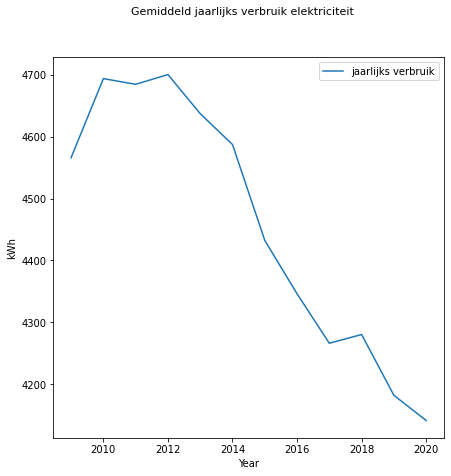

In [27]:
rdd_plot_elec = spark.sparkContext.parallelize(avg_per_year_elec)
df_plot_elec = rdd_plot_elec.toDF()
df_plot_elec = df_plot_elec.sort("_1")
x_axis = df_plot_elec.select("_1").rdd.flatMap(lambda x: x).collect()
y_axis = df_plot_elec.select("_2").rdd.flatMap(lambda x: x).collect()

figure_annual_consume_elec = plt.figure(figsize=(7, 7))
figure_annual_consume_elec.suptitle('Gemiddeld jaarlijks verbruik elektriciteit', fontsize=11)
plt_annual_consume_elec = figure_annual_consume_elec.add_subplot(111)
plt_annual_consume_elec.plot(x_axis, y_axis, label = "jaarlijks verbruik")
plt.xlabel("Year")
plt.ylabel("kWh")
plt.legend()
plt.show()

We merken ook hier een daling in het gemiddeld verbruik per jaar. De grafiek lijkt heel sterk op die van het gemiddel gasverbruik per jaar. We kunnen dus vastellen dat het verbuik van gas en elektriciteit is gedaald in Nederland. 


### 1.2.5 Totaal jaarlijks verbruik elektriciteit voor Stedin

+----+--------------------+
|year| sum(annual_consume)|
+----+--------------------+
|2018|        3.36143466E8|
|2015|        3.41415095E8|
|2013|        3.53113736E8|
|2014|        3.50699414E8|
|2019|        3.08992264E8|
|2020|3.2757932602999794E8|
|2012|         3.5827112E8|
|2009|        3.49525441E8|
|2016|        3.37275148E8|
|2010|        3.52483571E8|
|2011|          3.549008E8|
|2017|        3.34917779E8|
+----+--------------------+



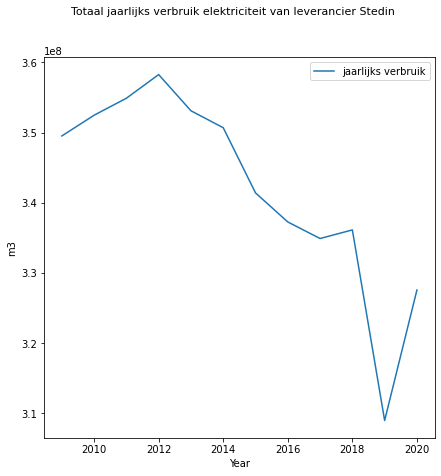

In [28]:
df_plot_elec_stedin = df_electricity.filter((df_electricity.file_name == "stedin_electricity_2009.csv") | \
          (df_electricity.file_name == "stedin_electricity_2010.csv") | \
          (df_electricity.file_name == "stedin_electricity_2011.csv") | \
          (df_electricity.file_name == "stedin_electricity_2012.csv") | \
          (df_electricity.file_name == "stedin_electricity_2013.csv") | \
          (df_electricity.file_name == "stedin_electricity_2014.csv") | \
          (df_electricity.file_name == "stedin_electricity_2015.csv") | \
          (df_electricity.file_name == "stedin_electricity_2016.csv") | \
          (df_electricity.file_name == "stedin_electricity_2017.csv") | \
          (df_electricity.file_name == "stedin_electricity_2018.csv") | \
          (df_electricity.file_name == "stedin_electricity_2019.csv") | \
          (df_electricity.file_name == "stedin_electricity_2020.csv")).groupBy('year').sum('annual_consume')
df_plot_elec_stedin.show()

df_plot_elec_stedin = df_plot_elec_stedin.sort("year")
x_axis = df_plot_elec_stedin.select("year").rdd.flatMap(lambda x: x).collect()
y_axis = df_plot_elec_stedin.select("sum(annual_consume)").rdd.flatMap(lambda x: x).collect()

figure_annual_consume_elec_total = plt.figure(figsize=(7, 7))
figure_annual_consume_elec_total.suptitle('Totaal jaarlijks verbruik elektriciteit van leverancier Stedin', fontsize=11)
plt_annual_consume_elec_total = figure_annual_consume_elec_total.add_subplot(111)
plt_annual_consume_elec_total.plot(x_axis, y_axis, label = "jaarlijks verbruik")
plt.xlabel("Year")
plt.ylabel("m3")
plt.legend()
plt.show()

Ook hier zien we de neerwaartse trend doorheen de jaren met weer een stijging in 2020. Ook dit kan misschien verklaard worden door een toename van klanten in 2020.

### 1.2.6 Totaal jaarlijks verbruik elektriciteit voor Liander

+----+-------------------+
|year|sum(annual_consume)|
+----+-------------------+
|2018|       6.03818753E8|
|2015|       6.10350391E8|
|2013|       6.38818469E8|
|2014|       6.30218197E8|
|2019|       5.97175596E8|
|2020|       5.99400177E8|
|2012|       6.43348537E8|
|2009|       6.28331827E8|
|2016|        6.1869838E8|
|2010|       6.37581928E8|
|2011|       6.39270907E8|
|2017|       6.10312935E8|
+----+-------------------+



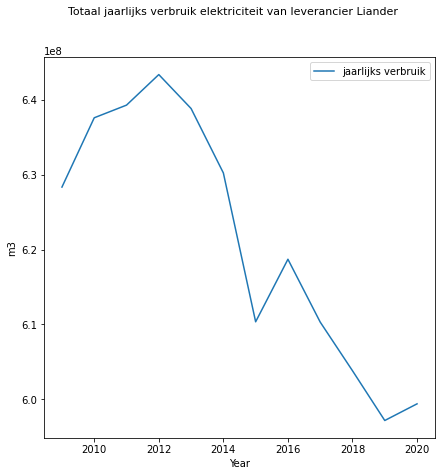

In [29]:
df_plot_elec_liander = df_electricity.filter((df_electricity.file_name == "liander_electricity_01012009.csv") | \
          (df_electricity.file_name == "liander_electricity_01012010.csv") | \
          (df_electricity.file_name == "liander_electricity_01012011.csv") | \
          (df_electricity.file_name == "liander_electricity_01012012.csv") | \
          (df_electricity.file_name == "liander_electricity_01012013.csv") | \
          (df_electricity.file_name == "liander_electricity_01012014.csv") | \
          (df_electricity.file_name == "liander_electricity_01012015.csv") | \
          (df_electricity.file_name == "liander_electricity_01012016.csv") | \
          (df_electricity.file_name == "liander_electricity_01012017.csv") | \
          (df_electricity.file_name == "liander_electricity_01012018.csv") | \
          (df_electricity.file_name == "liander_electricity_01012019.csv") | \
          (df_electricity.file_name == "liander_electricity_01012020.csv")).groupBy('year').sum('annual_consume')
df_plot_elec_liander.show()

df_plot_elec_liander = df_plot_elec_liander.sort("year")
x_axis = df_plot_elec_liander.select("year").rdd.flatMap(lambda x: x).collect()
y_axis = df_plot_elec_liander.select("sum(annual_consume)").rdd.flatMap(lambda x: x).collect()

figure_annual_consume_elec_total = plt.figure(figsize=(7, 7))
figure_annual_consume_elec_total.suptitle('Totaal jaarlijks verbruik elektriciteit van leverancier Liander', fontsize=11)
plt_annual_consume_elec_total = figure_annual_consume_elec_total.add_subplot(111)
plt_annual_consume_elec_total.plot(x_axis, y_axis, label = "jaarlijks verbruik")
plt.xlabel("Year")
plt.ylabel("m3")
plt.legend()
plt.show()

De grafiek vertoont ook hier een neerwaartse trend en lijkt sterk op die van het gemiddeld jaarlijks elektriciteitsverbruik.

### 1.2.7 Algemene conclusie

We stellen vast dat het gas- en elektriciteitsverbruik over het algemeneen jaar na jaar afneemt met hier en daar een lichte stijging. Maar de dalende trend blijft zich wel voortzetten.

###  1.2.8 Visualisatie totaal jaarlijks verbruik gas/elektriciteit per stad op map voor leveranciers Stedin/Liander

Als laatste zullen we het totaal jaarlijks verbruik van gas en elektriciteit voor de leveranciers Stedin en Liander per stad visualiseren op de kaart van Nederland.

### Elektriciteit

Bij de data ontbreken longitude en latitude coördinaten. Om te kunnen plotten op een map heb je deze waarden nodig. De naam van de stad is wel aanwezig. We zijn dan op zoek gegaan naar data van de steden van Nederland met hun longitude en latitude. We hebben een dataset gevonden hiervoor die de longitude en latitude bevat voor 944 prominente Nederlandse steden. 

Er is vreemd genoeg 1 stad in deze dataset die een Engelse naam heeft. Namelijk 'The Hague', die zullen we omzetten naar de Nederlands naam 'Den Haag'.

In [30]:
df_cities = spark.read.option("header","true").option("inferSchema", "true").csv("./data/nl.csv", sep=",")

In [31]:
df_cities = df_cities.withColumn('city', regexp_replace('city', 'The Hague', 'Den Haag'))

In [32]:
df_cities.show(vertical=True)

-RECORD 0--------------------------------
 city              | Den Haag            
 lat               | 52.0767             
 lng               | 4.2986              
 country           | Netherlands         
 iso2              | NL                  
 admin_name        | Zuid-Holland        
 capital           | primary             
 population        | 1406000             
 population_proper | 501725              
-RECORD 1--------------------------------
 city              | Amsterdam           
 lat               | 52.3667             
 lng               | 4.8833              
 country           | Netherlands         
 iso2              | NL                  
 admin_name        | Noord-Holland       
 capital           | primary             
 population        | 862965              
 population_proper | 862965              
-RECORD 2--------------------------------
 city              | Utrecht             
 lat               | 52.0908             
 lng               | 5.1222       

In [33]:
df_cities.printSchema()

root
 |-- city: string (nullable = true)
 |-- lat: double (nullable = true)
 |-- lng: double (nullable = true)
 |-- country: string (nullable = true)
 |-- iso2: string (nullable = true)
 |-- admin_name: string (nullable = true)
 |-- capital: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- population_proper: integer (nullable = true)



In [34]:
print(df_electricity.select(approx_count_distinct("city")).collect()[0][0])

21/12/15 16:58:02 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


2533


Wat we willen laten zien op de map is de hoeveelheid jaarlijks verbruik van elektriciteit of gas per stad. In de originele data zijn er veel meer steden aanwezig dan de data die we hebben kunnen vinden waarbij de longitude en latitude coördinaten zijn. We zullen hierdoor enkel de steden waarvoor we de coördinaten hebben kunnen laten zien. 

We moeten dus uit de df_electricity alle steden filteren die voorkomen in de 944 steden met longitude en latitude. Dit gebeurt als volgt:

In [35]:
print(df_cities.first())

Row(city='Den Haag', lat=52.0767, lng=4.2986, country='Netherlands', iso2='NL', admin_name='Zuid-Holland', capital='primary', population=1406000, population_proper=501725)


In [36]:
df_electricity = df_electricity.withColumn('city', lower(col('city')))

In [37]:
df_cities = df_cities.withColumn('city', lower(col('city')))

In [38]:
list_cities_with_lat_long = df_cities.select('city').rdd.flatMap(lambda x: x).collect()

In [39]:
df_electricity_filtered = df_electricity.filter(df_electricity.city.isin(list_cities_with_lat_long))


In [40]:
df_electricity_filtered.count()

3080965

In [41]:
df_electricity_filtered.select(countDistinct("city")).show()

21/12/15 16:58:23 WARN DAGScheduler: Broadcasting large task binary with size 1804.9 KiB
21/12/15 16:58:29 WARN DAGScheduler: Broadcasting large task binary with size 1255.9 KiB


+--------------------+
|count(DISTINCT city)|
+--------------------+
|                 811|
+--------------------+



In [42]:
df_electricity.select(countDistinct("city")).show()

+--------------------+
|count(DISTINCT city)|
+--------------------+
|                2624|
+--------------------+



Nu voegen we bij de df_electricity_filtered de longitude en latitude toe. 

In [43]:
df_electricity_filtered = df_electricity_filtered.join(df_cities, ['city'])

In [44]:
df_electricity_filtered

DataFrame[city: string, net_manager: string, purchase_area: string, street: string, zipcode_from: string, zipcode_to: string, num_connections: double, delivery_perc: double, perc_of_active_connections: double, type_conn_perc: double, type_of_connection: string, annual_consume: double, year: int, file_name: string, lat: double, lng: double, country: string, iso2: string, admin_name: string, capital: string, population: int, population_proper: int]

Als laatste moeten we nog enkel de data er uitfilteren van de leveranciers Stedin en Liander.

In [45]:
df_electricity_filtered = df_electricity_filtered.filter((df_electricity_filtered.file_name == "liander_electricity_01012009.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012010.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012011.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012012.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012013.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012014.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012015.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012016.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012017.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012018.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012019.csv") | \
          (df_electricity_filtered.file_name == "liander_electricity_01012020.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2009.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2010.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2011.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2012.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2013.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2014.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2015.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2016.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2017.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2018.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2019.csv") | \
          (df_electricity_filtered.file_name == "stedin_electricity_2020.csv"))

In [46]:
df_electricity_filtered.count()

2020639

In [47]:
df_electricity_filtered.select("year").distinct().collect()

[Row(year=2018),
 Row(year=2015),
 Row(year=2013),
 Row(year=2014),
 Row(year=2019),
 Row(year=2020),
 Row(year=2012),
 Row(year=2009),
 Row(year=2016),
 Row(year=2010),
 Row(year=2011),
 Row(year=2017)]

Er zijn 12 verschillende jaartallen die gaan van 2009 t.e.m 2020.

Nu kunnen we de map maken voor elektriciteit.

In [48]:
import folium
def show_annual_consume_electricity_map(year):
    map = folium.Map(location=[52.1326, 5.29131], zoom_start=7)

    df_electricity_map = df_electricity_filtered.filter(df_electricity_filtered.year == year)
    df_electricity_map = df_electricity_map.groupBy("city", "lat", "lng", "file_name").agg(sum("annual_consume").alias("annual_consume"))
    

    for row in df_electricity_map.rdd.collect():
        if row.annual_consume >= 1000000:
            radius = 10
        elif row.annual_consume >= 500000:
            radius = 5
        else:
            radius = 2
        if 'stedin' in row.file_name:
            color = 'blue'
        else:
            color = 'yellow'
        folium.CircleMarker(location=[row.lat, row.lng], radius=radius, color=color, fill_color=color, fill=True).add_to(map)
    return map

In [49]:
from IPython.display import HTML,display

form = """
<style>
    .ep-container {
        background-color: #f8f9fa; 
        width:300px; 
        padding:20px; 
        color: #495057;
    }
    .ep-button {
        padding:5px; 
        width: 100px; 
        border: none; 
        background-color: #ced4da; 
        color: #495057;
        transition: ease-in-out 0.1s;
    }
    .ep-button:hover {
        background-color: #adb5bd; 
        color: #343a40;
    }
    .ep-form-inputs-control {
        display: flex;
        flex-wrap: wrap;
        margin-top: 1em;
        margin-bottom: 2em;
    }
    .ep-input-wrapper {
        display: flex;
        margin-left: 1em;
        margin-right: 1em;
    }
</style>
<div class="ep-container">
<p> Select a year and press the Submit button to see the annual electricity consume for that year per city visualised on a map:<p>
<div class="ep-form-inputs-control">
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2009"><label>2009</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2010"><label>2010</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2011"><label>2011</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2012"><label>2012</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2013"><label>2013</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2014"><label>2014</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2015"><label>2015</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2016"><label>2016</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2017"><label>2017</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2018"><label>2018</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2019"><label>2019</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2020"><label>2020</label></div>
</div>
<button class="ep-button" type="button" onclick="set_vars_elec_map()">Submit</button>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars_elec_map(){
        var var_name_elec_map = 'inp_year_elec_map';
        var ele = document.getElementsByName('year');
        
        for(i = 0; i < ele.length; i++) {
                if(ele[i].checked)
                var var_value_elec_map = ele[i].value;
            }
        var command1 = var_name_elec_map + " = '" + var_value_elec_map+ "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell = IPython.notebook.get_cell(86);
        cell.execute();
        cell.focus_cell(86);
    }
</script>
"""

HTML(form + javascript)

In [74]:
print("Year: " + inp_year_elec_map + '\n' 'Stedin = Blue, Liander = Yellow')
show_annual_consume_electricity_map(inp_year_elec_map)

Year: 2016
Stedin = Blue, Liander = Yellow


### Gas

We zullen nu hetzelfde doen voor gas. 

In [52]:
df_gas = df_gas.withColumn('city', lower(col('city')))

In [53]:
df_gas_filtered = df_gas.filter(df_gas.city.isin(list_cities_with_lat_long))


In [54]:
df_gas_filtered = df_gas_filtered.join(df_cities, ['city'])

In [55]:
df_gas_filtered = df_gas_filtered.filter((df_gas_filtered.file_name == "liander_gas_01012009.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2010.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2011.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2012.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2013.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2014.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2015.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2016.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2017.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2018.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2019.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2020.csv") | \
          (df_gas_filtered.file_name == "stedin_gas_2009.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012010.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012011.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012012.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012013.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012014.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012015.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012016.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012017.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012018.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012019.csv") | \
          (df_gas_filtered.file_name == "liander_gas_01012020.csv"))

In [56]:
df_gas_filtered.select("year").distinct().show()

+----+
|year|
+----+
|2018|
|2015|
|2013|
|2014|
|2019|
|2020|
|2012|
|2009|
|2016|
|2010|
|2011|
|2017|
+----+



In [57]:
import folium
def show_annual_consume_gas_map(year):
    map = folium.Map(location=[52.1326, 5.29131], zoom_start=7)

    df_gas_map = df_gas_filtered.filter(df_gas_filtered.year == year)
    df_gas_map = df_gas_map.groupBy("city", "lat", "lng", "file_name").agg(sum("annual_consume").alias("annual_consume"))
    

    for row in df_gas_map.rdd.collect():
        if row.annual_consume >= 1000000:
            radius = 10
        elif row.annual_consume >= 500000:
            radius = 5
        else:
            radius = 2
        if 'stedin' in row.file_name:
            color = 'blue'
        else:
            color = 'yellow'
        folium.CircleMarker(location=[row.lat, row.lng], radius=radius, color=color, fill_color=color, fill=True).add_to(map)
    return map

In [58]:
from IPython.display import HTML,display

form = """
<style>
    .ep-container {
        background-color: #f8f9fa; 
        width:300px; 
        padding:20px; 
        color: #495057;
    }
    .ep-button {
        padding:5px; 
        width: 100px; 
        border: none; 
        background-color: #ced4da; 
        color: #495057;
        transition: ease-in-out 0.1s;
    }
    .ep-button:hover {
        background-color: #adb5bd; 
        color: #343a40;
    }
    .ep-form-inputs-control {
        display: flex;
        flex-wrap: wrap;
        margin-top: 1em;
        margin-bottom: 2em;
    }
    .ep-input-wrapper {
        display: flex;
        margin-left: 1em;
        margin-right: 1em;
    }
</style>
<div class="ep-container">
<p> Select a year and press the Submit button to see the annual gas consume for that year per city visualised on a map:<p>
<div class="ep-form-inputs-control">
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2009"><label>2009</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2010"><label>2010</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2011"><label>2011</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2012"><label>2012</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2013"><label>2013</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2014"><label>2014</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2015"><label>2015</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2016"><label>2016</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2017"><label>2017</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2018"><label>2018</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2019"><label>2019</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2020"><label>2020</label></div>
</div>
<button class="ep-button" type="button" onclick="set_vars_gas_map()">Submit</button>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars_gas_map(){
        var var_name_gas_map = 'inp_year_gas_map';
        var ele = document.getElementsByName('year');
        
        for(i = 0; i < ele.length; i++) {
                if(ele[i].checked)
                var var_value_gas_map = ele[i].value;
            }
        var command1 = var_name_gas_map + " = '" + var_value_gas_map+ "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell = IPython.notebook.get_cell(96);
        cell.execute();
        cell.focus_cell(96);
    }
</script>
"""

HTML(form + javascript)

In [75]:
print("Year: " + inp_year_gas_map + '\n' 'Stedin = Blue, Liander = Yellow')
show_annual_consume_gas_map(inp_year_gas_map)

Year: 2016
Stedin = Blue, Liander = Yellow


## 2. Elektriciteitsproductie

We nemen ook een kijkje naar de elektriciteitsproductie in Nederland. Hoe evolueert dit doorheen de jaren en wat is het aandeel van hernieuwbare energie in de elektriciteitsproductie ?

### 2.1 Voorbereiding

In [61]:
df_electricity_production = spark.read.option("header","true").option("inferSchema", "true").csv("./data/Elektriciteit__aanbod_en_verbruik_12102021_102309.csv", sep=";")
electricity_production_raw = sc.textFile("./data/Elektriciteit__aanbod_en_verbruik_12102021_102309.csv")

df_electricity_production.show(vertical = True)
df_electricity_production.printSchema()

-RECORD 0---------------------------------------------------------------------------------
 Perioden                                                                        | 2013   
 Bruto productie (mln kWh)                                                       | 100875 
 Eigen verbruik bij elektr.productie (mln kWh)                                   | 3505   
 Netto productie/Netto productie, totaal (mln kWh)                               | 97370  
 Netto productie/Kernenergie (mln kWh)                                           | null   
 Netto productie/Brandstoffen/Brandstoffen, totaal (mln kWh)                     | null   
 Netto productie/Brandstoffen/Kolen (mln kWh)                                    | null   
 Netto productie/Brandstoffen/Olieproducten (mln kWh)                            | null   
 Netto productie/Brandstoffen/Aardgas (mln kWh)                                  | null   
 Netto productie/Brandstoffen/Biomassa (mln kWh)                                 | 5277   

In [62]:

electricity_production_parts = electricity_production_raw.map(lambda l: l.split(";"))
electricity_production_rows = electricity_production_parts.map(lambda l: Row(periode=l[0], netto_productie=l[3],
                                                                             netto_productie_brandstoffen=l[5],
                                                                             netto_productie_windenergie=l[12],
                                                                             netto_productie_zonnestroom=l[15],
                                                                             netto_verbruik=l[30]))

In [63]:
electricity_production_rows.take(5)


[Row(periode='"Perioden"', netto_productie='"Netto productie/Netto productie, totaal (mln kWh)"', netto_productie_brandstoffen='"Netto productie/Brandstoffen/Brandstoffen, totaal (mln kWh)"', netto_productie_windenergie='"Netto productie/Windenergie/Windenergie, totaal (mln kWh)"', netto_productie_zonnestroom='"Netto productie/Zonnestroom (mln kWh)"', netto_verbruik='"Netto verbruik (berekend) (mln kWh)"'),
 Row(periode='"2013"', netto_productie='97370', netto_productie_brandstoffen='', netto_productie_windenergie='5627', netto_productie_zonnestroom='410', netto_verbruik='111099'),
 Row(periode='"2014"', netto_productie='99310', netto_productie_brandstoffen='', netto_productie_windenergie='5797', netto_productie_zonnestroom='725', netto_verbruik='109103'),
 Row(periode='"2015"', netto_productie='105902', netto_productie_brandstoffen='91907', netto_productie_windenergie='7550', netto_productie_zonnestroom='1109', netto_verbruik='109386'),
 Row(periode='"2016"', netto_productie='111032',

In [64]:

header = electricity_production_rows.first()
df_electricity_production = spark.createDataFrame(electricity_production_rows.filter(lambda row: row != header))

We zetten voor alle kolommen de datatypes juist en zorgen ervoor dat de kolom 'periode' geen speciale tekens bevat.

In [65]:
df_electricity_production.show()

df2_electricity_production = df_electricity_production.selectExpr("cast(periode as string) periode",
                                                                  "cast(netto_productie as int) netto_productie",
                                                                  "cast(netto_productie_brandstoffen as int) netto_productie_brandstoffen",
                                                                  "cast(netto_productie_windenergie as int) netto_productie_windenergie",
                                                                  "cast(netto_productie_zonnestroom as int) netto_productie_zonnestroom",
                                                                  "cast(netto_verbruik as int) netto_verbruik")
df2_electricity_production.printSchema()

df2_electricity_production = df2_electricity_production.withColumn('periode', regexp_replace('periode', '["*]', ''))
df2_electricity_production.show()

+--------+---------------+----------------------------+---------------------------+---------------------------+--------------+
| periode|netto_productie|netto_productie_brandstoffen|netto_productie_windenergie|netto_productie_zonnestroom|netto_verbruik|
+--------+---------------+----------------------------+---------------------------+---------------------------+--------------+
|  "2013"|          97370|                            |                       5627|                        410|        111099|
|  "2014"|          99310|                            |                       5797|                        725|        109103|
|  "2015"|         105902|                       91907|                       7550|                       1109|        109386|
|  "2016"|         111032|                       96122|                       8170|                       1602|        110513|
|  "2017"|         113465|                       95895|                      10569|                       2204|

### 2.2 Analyse

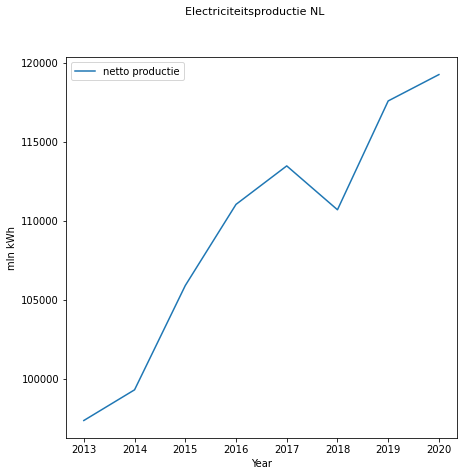

In [84]:
# Get values from the needed columns in a List to use them to plot.
x_axis = df2_electricity_production.rdd.map(lambda l:l.periode).collect()
y_axis1 = df2_electricity_production.rdd.map(lambda l:l.netto_productie).collect()
figure_netto_production = plt.figure(figsize=(7, 7))
figure_netto_production.suptitle('Electriciteitsproductie NL', fontsize=11)
plt1 = figure_netto_production.add_subplot(111)
plt1.plot(x_axis, y_axis1, label = "netto productie")
plt.xlabel("Year")
plt.ylabel("mln kWh")
plt.legend()
plt.show()

We zien dat de elektriciteitsproductie doorheen de jaren stijgt.

We zullen nu bekijken hoe groot het aandeel is van hernieuwbare energie in de elektriciteitsproductie.

In [80]:

labels = "Brandstoffen","Windenergie","Zonnestroom"
def show_renewable_energy_share(year):
    energy_distribution = df2_electricity_production.filter(df2_electricity_production.periode == year).collect()

    data = [energy_distribution[0].asDict()["netto_productie_brandstoffen"],energy_distribution[0].asDict()["netto_productie_windenergie"],energy_distribution[0].asDict()["netto_productie_zonnestroom"]]
 
    explode = (0, 0.1, 0.1)  # highlight the 2nd and 3rd slice of the pie chart
    fig1, ax1 = plt.subplots()
    plt.title('Electriciteitsproductie ' + str(year))
    ax1.pie(data, explode=explode, labels=labels, autopct='%1.1f%%',
    shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

In [81]:
from IPython.display import HTML,display

form = """
<style>
    .ep-container {
        background-color: #f8f9fa; 
        width:300px; 
        padding:20px; 
        color: #495057;
    }
    .ep-button {
        padding:5px; 
        width: 100px; 
        border: none; 
        background-color: #ced4da; 
        color: #495057;
        transition: ease-in-out 0.1s;
    }
    .ep-button:hover {
        background-color: #adb5bd; 
        color: #343a40;
    }
    .ep-form-inputs-control {
        display: flex;
        flex-wrap: wrap;
        margin-top: 1em;
        margin-bottom: 2em;
    }
    .ep-input-wrapper {
        display: flex;
        margin-left: 1em;
        margin-right: 1em;
    }
</style>
<div class="ep-container">
<p> Select a year and press the Submit button to see how much the share of renewable energy is of the entire electricity production for that year:<p>
<div class="ep-form-inputs-control">
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2015"><label>2015</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2016"><label>2016</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2017"><label>2017</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2018"><label>2018</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2019"><label>2019</label></div>
    <div class="ep-input-wrapper"><input type="radio" name="year" value="2020"><label>2020</label></div>
</div>
<button class="ep-button" type="button" onclick="set_vars()">Submit</button>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars(){
        var var_name1 = 'inp_year';
        var ele = document.getElementsByName('year');
        
        for(i = 0; i < ele.length; i++) {
                if(ele[i].checked)
                var var_value1 = ele[i].value;
            }
        var command1 = var_name1 + " = '" + var_value1 + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command1);
        cell = IPython.notebook.get_cell(110);
        cell.execute();
        cell.focus_cell(110);
    }
</script>
"""

HTML(form + javascript)

Year: 2018


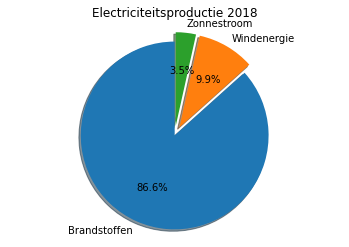

In [82]:
print("Year: " + inp_year)
show_renewable_energy_share(int(inp_year))

Als je de pie chart bekijkt van de verschillende jaren dan zie je dat er toch meer en meer ingezet wordt op hernieuwbare energie en dat de elektriciteitsproductie door middel van het verbranden van brandstoffen ieder jaar afneemt. 